In [2]:
!pip install pandas matplotlib wandb numpy


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
save_plots_dir = '/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/paper_plots'


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd

def wandb_viz_loss_subplot(exp_data, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                           wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    Plots training and validation losses for multiple experiments as subplots in a single figure.
    """
    wandb.login()

    num_experiments = len(exp_data)
    fig, axs = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 4), squeeze=False)

    for idx, (label, runs) in enumerate(exp_data):
        losses_dict = {}
        for run_id in runs:
            api = wandb.Api()
            run = api.run(f"{wandb_user}/{wandb_project}/{run_id}")
            history = run.history(keys=list(loss_types.keys()))
            for loss_key in loss_types:
                if loss_key not in losses_dict:
                    losses_dict[loss_key] = []
                losses_dict[loss_key].append(history[loss_key].values)

        ax = axs[0, idx]
        for loss_key, loss_label in loss_types.items():
            loss_arrays = losses_dict[loss_key]
            min_len = min(len(arr) for arr in loss_arrays)
            loss_arrays = [arr[:min_len] for arr in loss_arrays]
            loss_stack = np.vstack(loss_arrays)
            mean_loss = np.mean(loss_stack, axis=0)
            std_loss = np.std(loss_stack, axis=0)
            steps = np.arange(len(mean_loss))

            ax.plot(steps, mean_loss, label=loss_label)
            ax.fill_between(steps, mean_loss - std_loss, mean_loss + std_loss, alpha=0.3)

        ax.set_title(label)
        ax.set_xlabel("Steps")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/combined_loss_plot.png")
    plt.show()


In [5]:
def wandb_final_loss_with_std(exp_data, loss_types=None, save_dir=None, exclude=None, wandb_user='moritz-hauschulz', 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    Prints a table of averaged final losses and their standard deviations for each loss type.
    
    Args:
        exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...]
        loss_types: dict mapping loss variable names (in wandb) to display names
    """
    wandb.login()
    api = wandb.Api()

    if loss_types is None:
        raise ValueError("loss_types must be provided and map wandb variable names to display labels.")

    table_rows = []

    for label, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        row = {'Label': label}
        
        for loss_var, display_name in loss_types.items():
            final_losses = []
            
            for exp_id in exp_ids:
                try:
                    run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                    history = run.history(keys=[loss_var])
                    values = history[loss_var].dropna().values
                    if len(values) > 0:
                        final_losses.append(values[-1])
                except Exception as e:
                    print(f"Skipping run {exp_id} due to error: {e}")
            
            if final_losses:
                mean_loss = np.mean(final_losses)
                std_loss = np.std(final_losses)
                row[f"{display_name}"] = f"{mean_loss:.2e} ± {std_loss:.1e}"
            else:
                row[f"{display_name}"] = "N/A"
        
        table_rows.append(row)

    df = pd.DataFrame(table_rows)
    print(df.to_string(index=False))
    
    if save_dir:
        df.to_csv(f"{save_dir}/final_loss_summary.csv", index=False)

In [6]:
def visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_dir):
    # List to store DataFrames
    dfs = []
    
    # Read all CSV files for the given parameters
    for exp_num in experiment_numbers:
        data_dir = f'/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/{experiment_name}/exp_n_{exp_num}/plots'
        csv_path = f'{data_dir}/data_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_val.csv'
        
        try:
            df = pd.read_csv(csv_path)
            dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: File {csv_path} not found")
    
    if not dfs:
        print("No data files found")
        return
        
    # Calculate mean and std for each column
    combined_df = pd.concat(dfs)
    mean_df = combined_df.groupby('time').mean()
    std_df = combined_df.groupby('time').std()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1])
    
    colors = plt.cm.tab10(np.linspace(0, 1, 4))
    
    # Plot position/velocity data in first subplot
    ax1.plot(mean_df.index, mean_df['true_position'], '--', color=colors[0], label='true position')
    ax1.plot(mean_df.index, mean_df['predicted_position'], '-', color=colors[0], label='predicted position')
    ax1.fill_between(mean_df.index, 
                     mean_df['predicted_position'] - std_df['predicted_position'],
                     mean_df['predicted_position'] + std_df['predicted_position'],
                     color=colors[0], alpha=0.2)
    
    if 'true_velocity' in mean_df.columns:
        ax1.plot(mean_df.index, mean_df['true_velocity'], '--', color=colors[1], label='true velocity')
        ax1.plot(mean_df.index, mean_df['predicted_velocity'], '-', color=colors[1], label='predicted velocity')
        ax1.fill_between(mean_df.index,
                        mean_df['predicted_velocity'] - std_df['predicted_velocity'],
                        mean_df['predicted_velocity'] + std_df['predicted_velocity'],
                        color=colors[1], alpha=0.2)
    
    # Plot energy data in second subplot
    ax2.plot(mean_df.index, mean_df['true_energy'], '-', color=colors[2], label='true energy')
    ax2.plot(mean_df.index, mean_df['gradient_predicted_energy'], '-.', color=colors[3], label='gradient-predicted energy')
    ax2.fill_between(mean_df.index,
                     mean_df['gradient_predicted_energy'] - std_df['gradient_predicted_energy'],
                     mean_df['gradient_predicted_energy'] + std_df['gradient_predicted_energy'],
                     color=colors[3], alpha=0.2)
    
    if 'velocity_predicted_energy' in mean_df.columns:
        ax2.plot(mean_df.index, mean_df['velocity_predicted_energy'], '--', color=colors[2], label='velocity-predicted energy')
        ax2.fill_between(mean_df.index,
                        mean_df['velocity_predicted_energy'] - std_df['velocity_predicted_energy'],
                        mean_df['velocity_predicted_energy'] + std_df['velocity_predicted_energy'],
                        color=colors[2], alpha=0.2)
    
    # Set labels and titles
    ax1.set_ylabel('Position / Velocity', fontsize=14)
    ax1.set_title(f'Position and Velocity Predictions\n$q_0$={q0:.2f}, $p_0$={p0:.2f}, $\\omega$={omega:.2f}', fontsize=16, pad=20)
    ax1.grid(True)
    ax1.legend(fontsize=12)
    
    ax2.set_xlabel('Time', fontsize=14)
    ax2.set_ylabel('Energy', fontsize=14)
    ax2.set_title('Energy Predictions', fontsize=16, pad=20)
    ax2.grid(True)
    ax2.legend(fontsize=12)
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'{save_dir}/averaged_predictions_with_energy_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_{experiment_label}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [7]:
vanilla =["20250416-234824", "20250417-000822",	"20250417-001352",	"20250417-001916",	"20250417-002439"]
qr = ["20250417-003016",	"20250417-004209",	"20250417-005335",	"20250417-010509",	"20250417-011628"]
normal = ["20250417-092318",	"20250417-093241",	"20250417-095220","20250417-095220",  "20250417-100212"]
implicit = ["20250417-012917",	"20250417-014052",	"20250417-015227",	"20250417-020402",	"20250417-021535"]

**Vanilla Plots**

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: moritz-hauschulz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


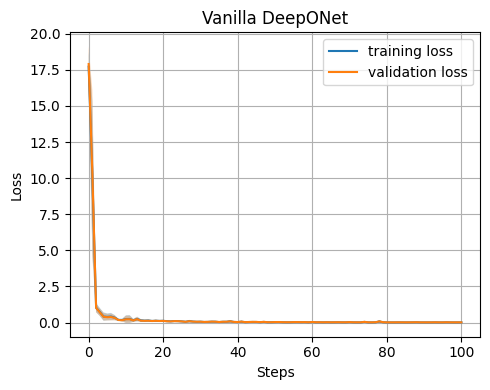

In [9]:
exp_data = [('Vanilla DeepONet',vanilla)]
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss'}

wandb_viz_loss_subplot(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

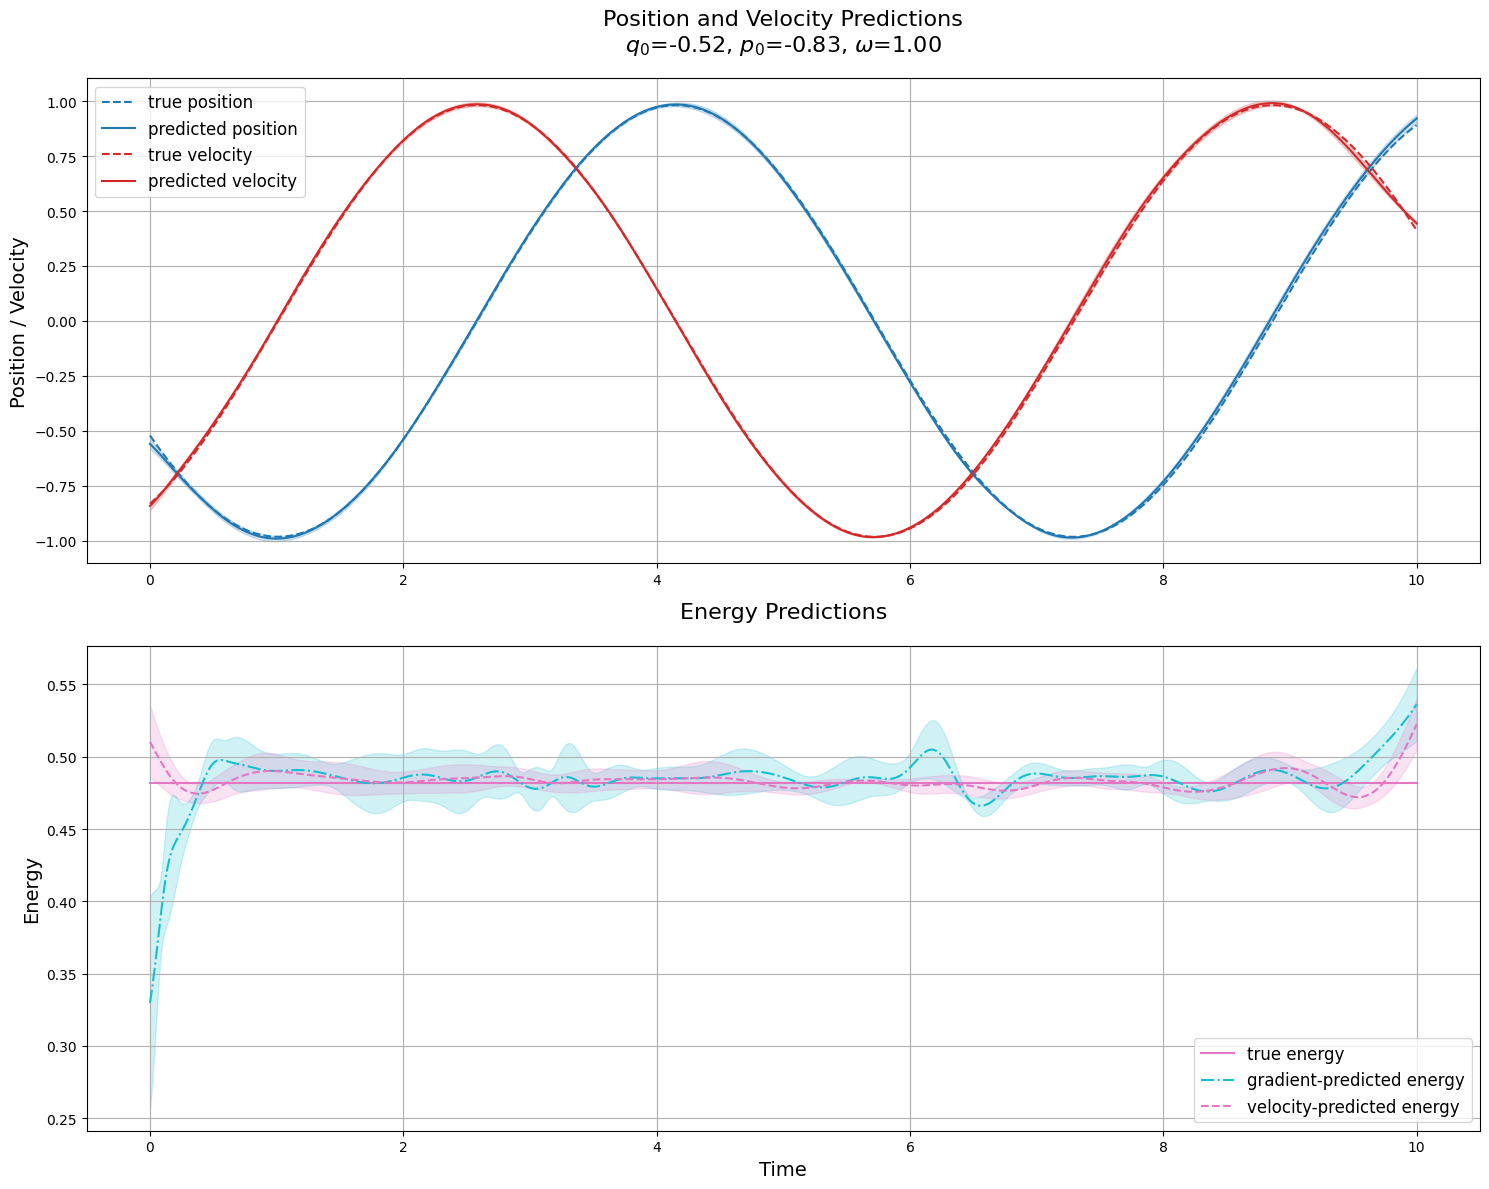

In [ ]:
experiment_name = 'harmonic_osc_1_1'


experiment_label = 'Vanilla DeepONet'
experiment_numbers = vanilla

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



In [31]:
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss', 'current_energy_loss_val':'implicit energy loss', 'learned_energy_loss_val':'learned energy loss'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

           Label      training loss    validation loss implicit energy loss learned energy loss
Vanilla DeepONet 9.27e-03 ± 3.2e-03 1.40e-02 ± 2.9e-03   4.51e+00 ± 5.2e-02  4.46e+00 ± 4.4e-02


**QR plots**

In [32]:
exp_data = [('QR DeepONet',qr)]
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss'}

wandb_viz_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

<built-in method items of dict object at 0x16a45f5c0>


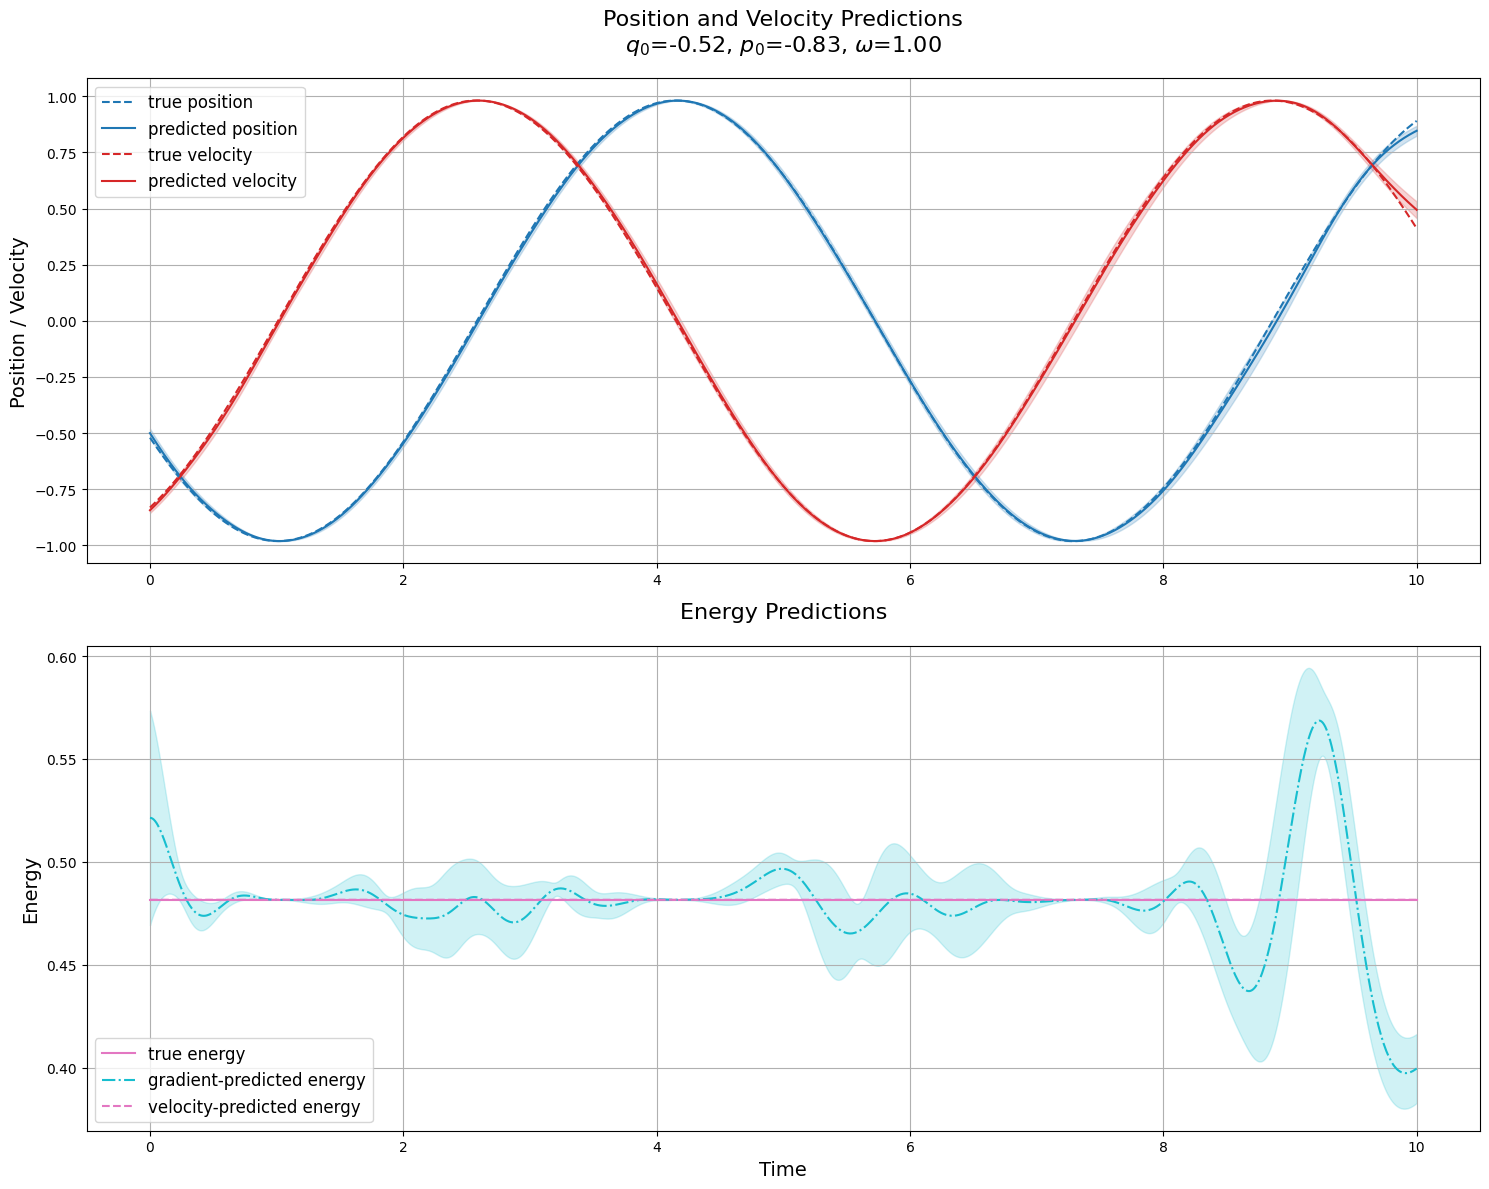

In [19]:
experiment_name = 'harmonic_osc_1_2'


experiment_label = 'Vanilla DeepONet'
experiment_numbers = qr

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



In [33]:
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss', 'current_energy_loss_val':'implicit energy loss', 'learned_energy_loss_val':'learned energy loss'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

      Label      training loss    validation loss implicit energy loss learned energy loss
QR DeepONet 1.97e-02 ± 1.3e-02 2.10e-02 ± 1.1e-02   9.03e+00 ± 6.6e-02  8.24e-13 ± 9.2e-14


**normalized plots**


In [34]:
exp_data = [('Normalized DeepONet',normal)]
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss'}

wandb_viz_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

<built-in method items of dict object at 0x16a205980>


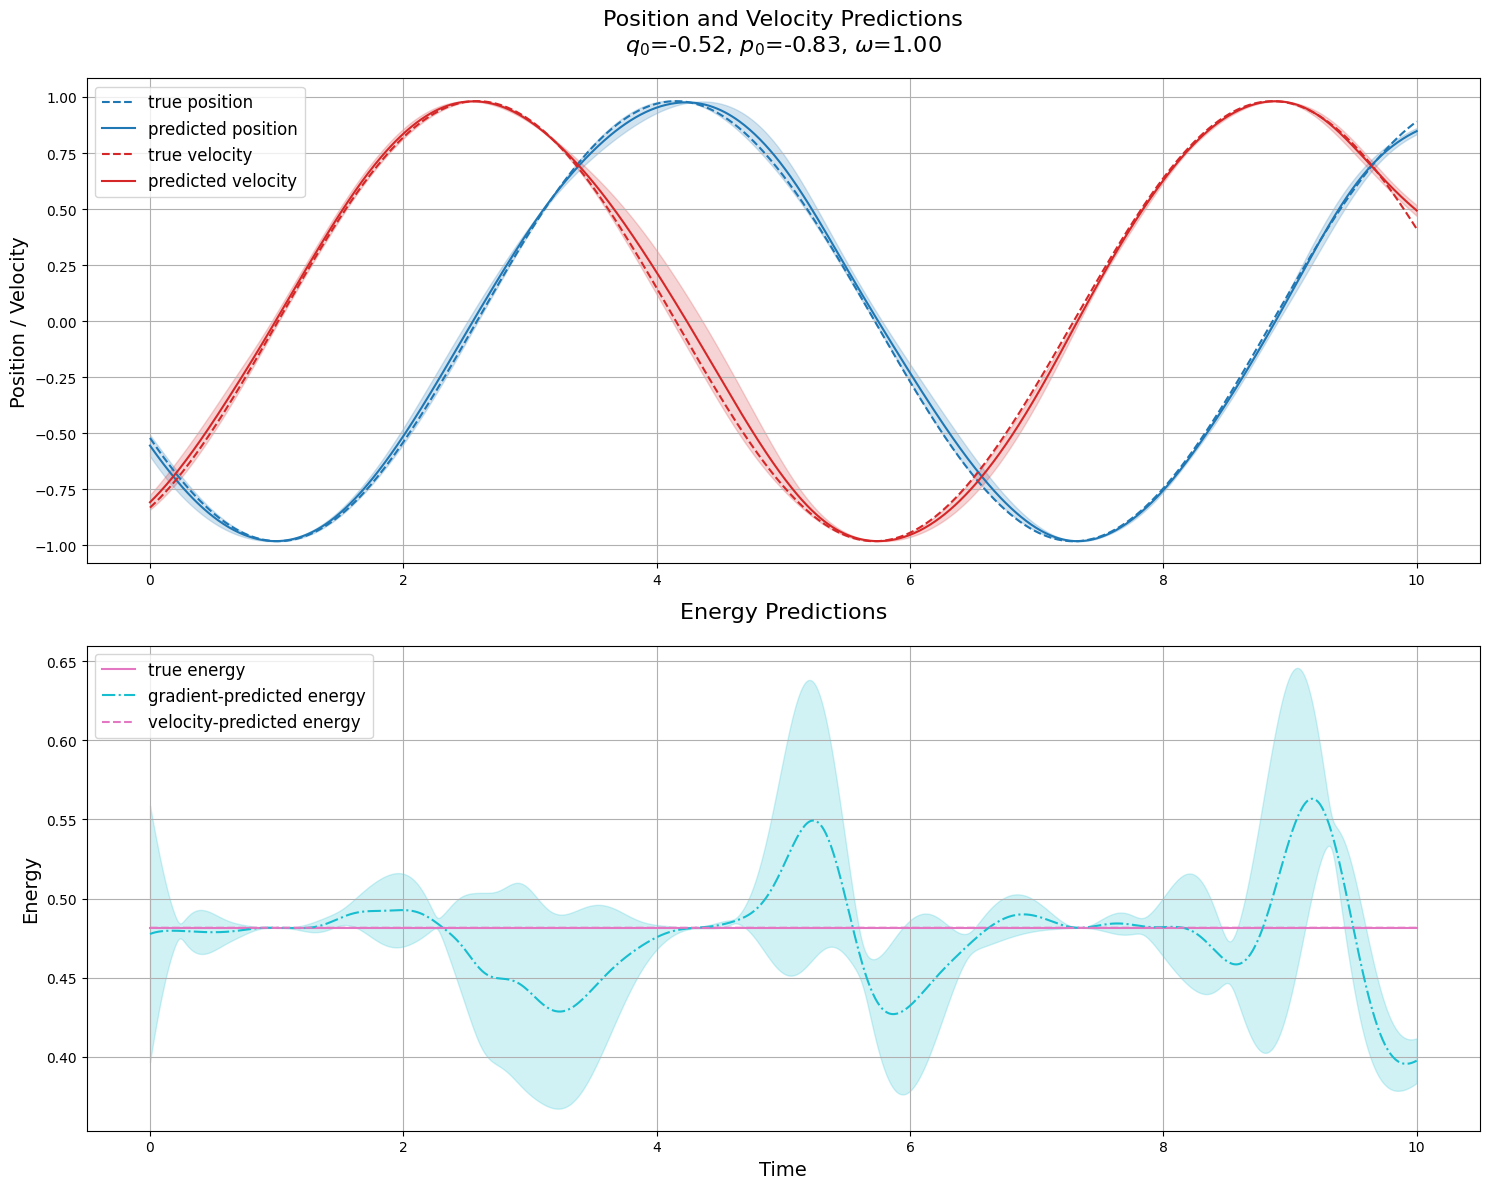

In [21]:
experiment_name = 'harmonic_osc_1_3'

experiment_label = 'Vanilla DeepONet'
experiment_numbers = normal

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



In [35]:
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss', 'current_energy_loss_val':'implicit energy loss', 'learned_energy_loss_val':'learned energy loss'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

              Label      training loss    validation loss implicit energy loss learned energy loss
Normalized DeepONet 8.34e-02 ± 8.2e-02 8.64e-02 ± 8.6e-02   3.76e-01 ± 3.3e-01  3.72e-13 ± 9.7e-15


**implicit normalized plots**

In [36]:
exp_data = [('Normalized DeepONet',implicit)]
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss'}

wandb_viz_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

<built-in method items of dict object at 0x16a1768c0>


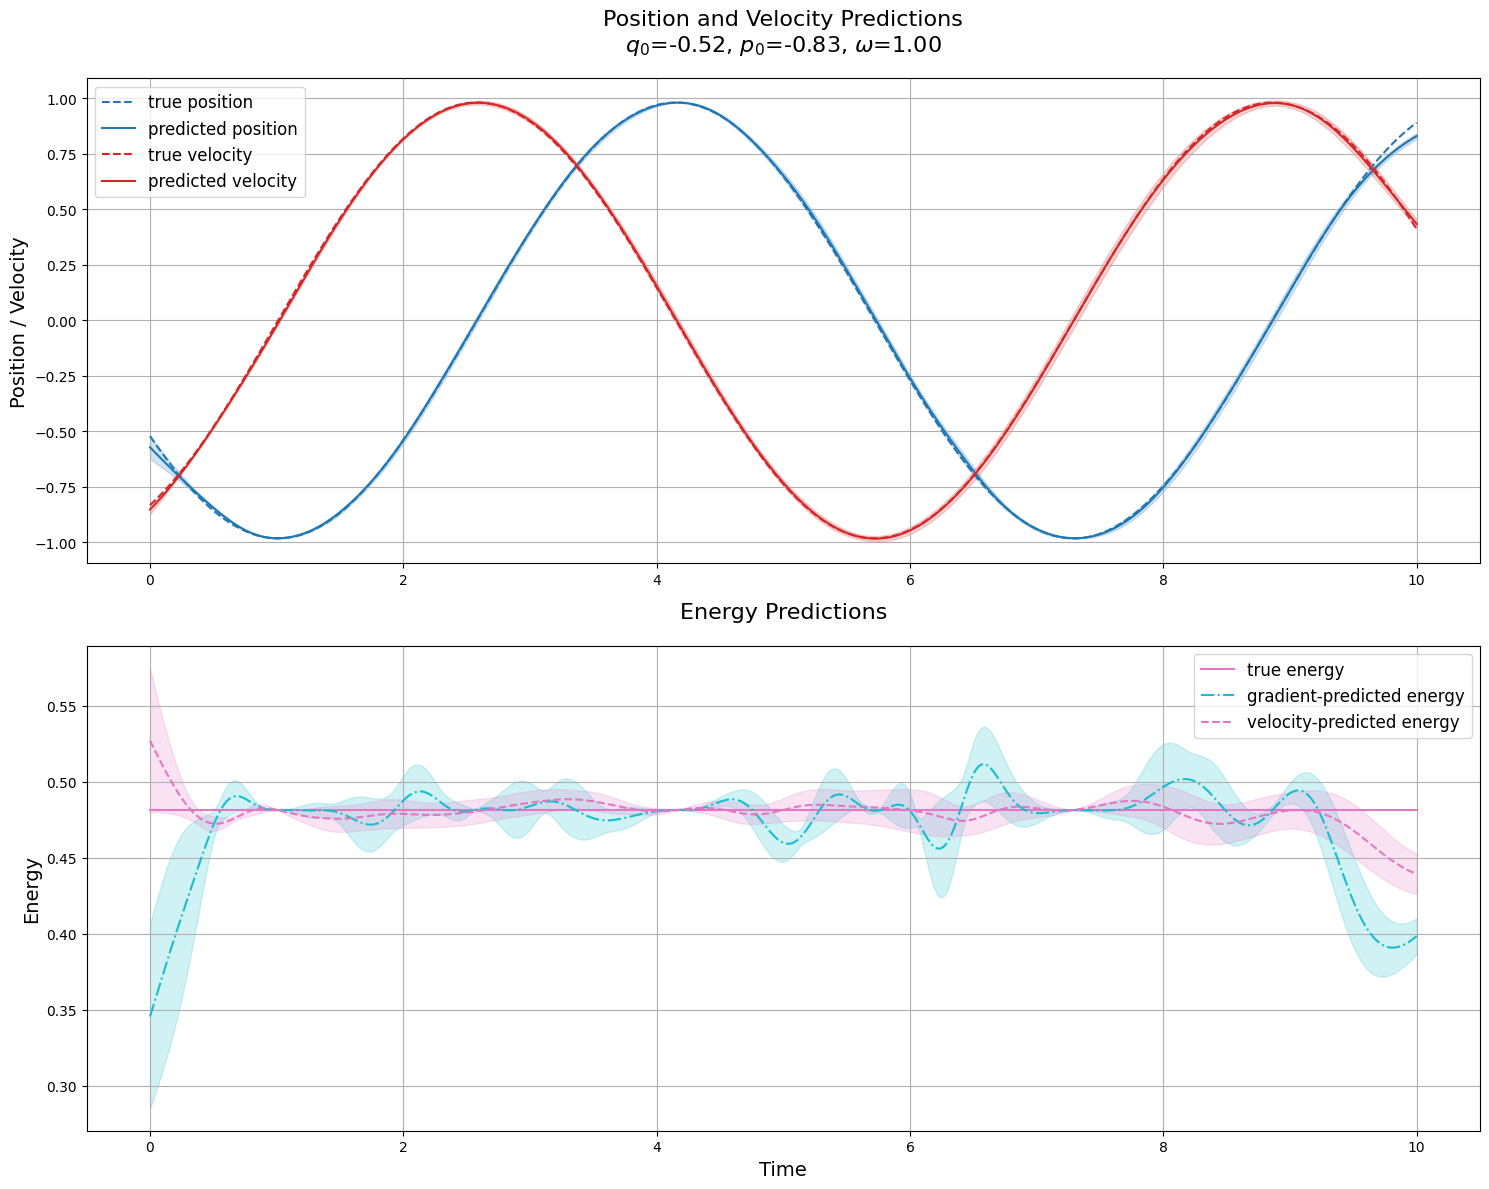

In [22]:
experiment_name = 'harmonic_osc_1_4'

experiment_label = 'Vanilla DeepONet'
experiment_numbers = implicit

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir)



In [37]:
loss_types = {'mse_loss_train': 'training loss', 'mse_loss_val': 'validation loss', 'current_energy_loss_val':'implicit energy loss', 'learned_energy_loss_val':'learned energy loss'}

wandb_final_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

              Label      training loss    validation loss implicit energy loss learned energy loss
Normalized DeepONet 2.14e-02 ± 1.2e-02 2.35e-02 ± 1.1e-02   1.15e-01 ± 4.2e-02  7.59e-02 ± 3.6e-02
